In [203]:
import cv2
import numpy as  np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Given a colored image, converts it to grayscale
def to_gray(img, r_frac, g_frac, b_frac):
    # first create an empty numpy array for the gray image
    h = img.shape[0]
    w = img.shape[1]
    grey_img = np.full((h, w), 0, dtype=np.uint8)
    for y in range(h):
        for x in range(w):
            # calculate each new pixel based on the given fractions
            total = r_frac * img[y,x,0] + g_frac * img[y,x,1] + b_frac * img[y,x,2]
            grey_img[y,x] = np.uint8(total)
    return grey_img

# Given a grayscale image, apply full-scale contrast stretching
def contrast_stretching(image):
    new_img = image.copy()
    a = image.min()
    b = image.max()
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            new_img[y,x] = 255 * (image[y,x] - a) / (b - a)
    return new_img

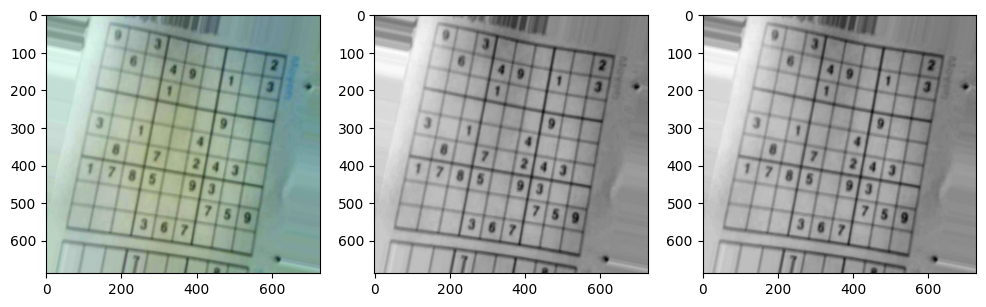

In [14]:
image = cv2.imread("sudoku_test_1.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = to_gray(image, 1/3, 1/3, 1/3)
fscs = contrast_stretching(gray)

f, plot = plt.subplots(1, 3, figsize=(12,12))
plot[0].imshow(image)
plot[1].imshow(gray, cmap='gray')
plot[2].imshow(fscs, cmap='gray')


In [155]:
# Given a grayscale image, apply a gaussian blur to the image
def gaussian_blur(img, size, sig):
    # create a 2d array of gaussian pdf values
    filter = np.zeros((size, size), dtype=np.float32)
    for i in range(-size//2, size//2):
        for j in range(-size//2, size//2):
            filter[i+(size//2), j+(size//2)] = (1/(2.0 * np.pi * sig**2.0)) * np.exp(-1.0*(i**2.0 + j**2.0)/(2.0 * sig**2.0))
    filter /= np.sum(filter)

    # blur the image using convolution
    #   first get sizes
    imgH, imgW = img.shape 
    filH, filW = filter.shape
    #   Create empty array
    temp = np.zeros((imgH-filH+1, imgW-filW+1), dtype=float)   
    #   calc each pixel by sum
    for i in range(filH//2, imgH-filH+1):
        for j in range(filW//2, imgW-filW+1):
            temp[i, j] = np.sum(img[i-filH//2:i+filH//2 + 1, j-filW//2:j+filW//2 + 1] * filter)
    return temp

def adaptive_thresh(img, size, sig, c):
    #First apply gaussian blurring
    blur = gaussian_blur(img, size, sig)
    #Next subtract a constant thresh value
    thresh = blur - c
    #binarize
    threshH, threshW = thresh.shape
    bin = np.zeros((threshH, threshW), dtype=np.uint8)
    img_temp = img[0:threshH, 0:threshW]
    bin[img_temp >= thresh] = 255

    return thresh, img_temp, bin


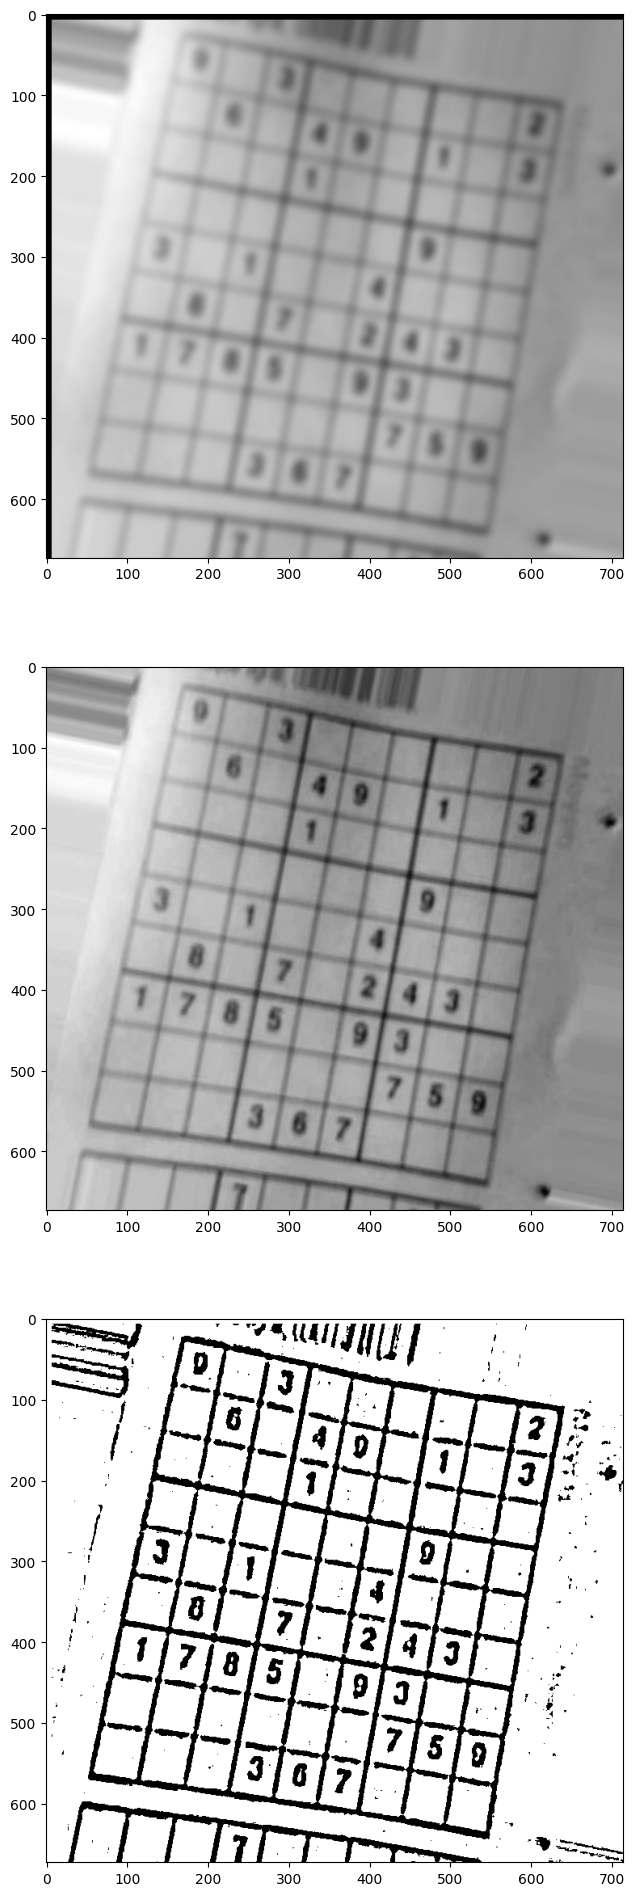

In [157]:
thresh, img_temp, bin = adaptive_thresh(gray, 15, 5, 3)

f, plot = plt.subplots(3, 1, figsize=(24,24))
plot[0].imshow(thresh, cmap='gray')
plot[1].imshow(img_temp, cmap='gray')
plot[2].imshow(bin, cmap='gray')

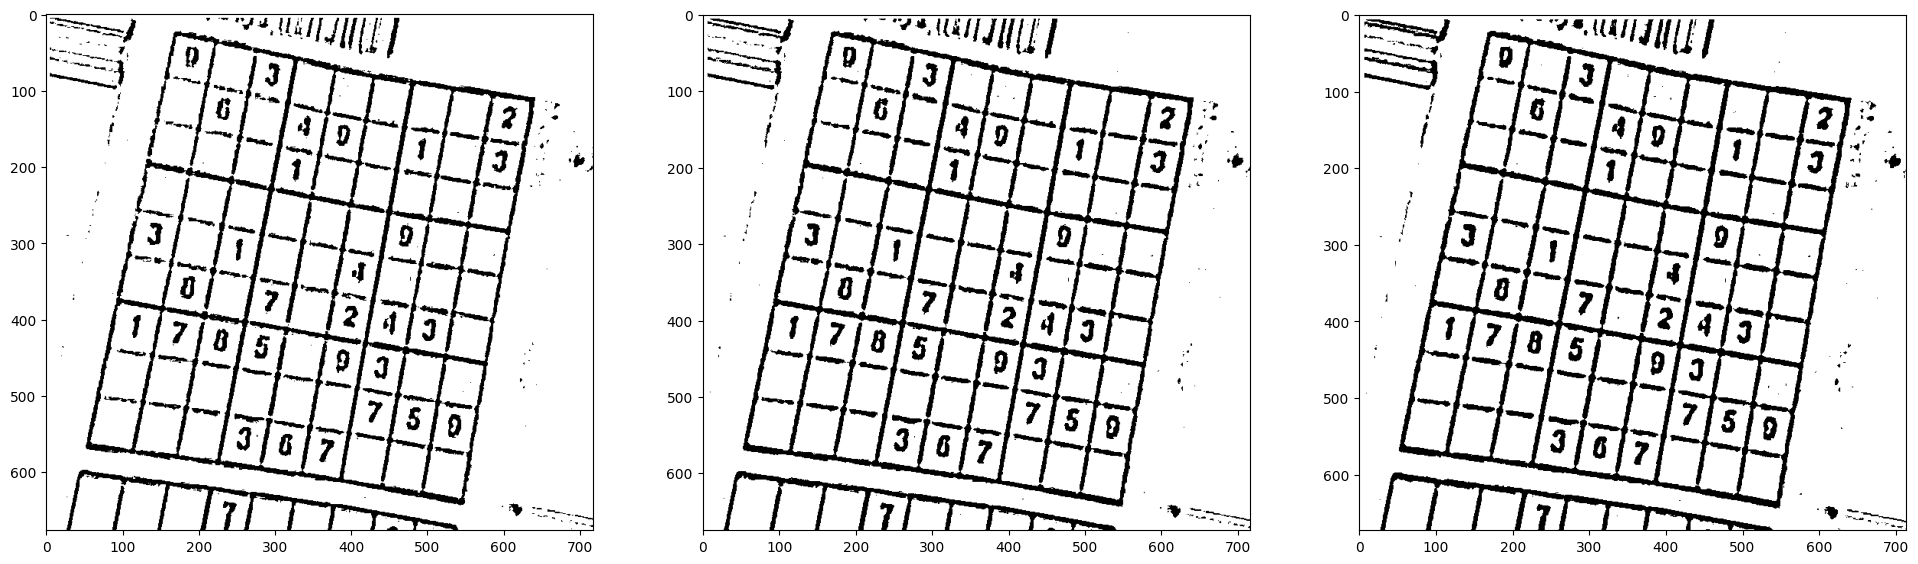

In [162]:
f, plot = plt.subplots(1, 3, figsize=(24,24))
plot[0].imshow(adaptive_thresh(gray, 11, 6, 4)[2], cmap='gray')
plot[1].imshow(adaptive_thresh(gray, 13, 6, 4)[2], cmap='gray')
plot[2].imshow(adaptive_thresh(gray, 15, 6, 4)[2], cmap='gray')

In [163]:
thresh = adaptive_thresh(gray, 15, 6, 4)[2]

Text(0.5, 1.0, 'img_ Median')

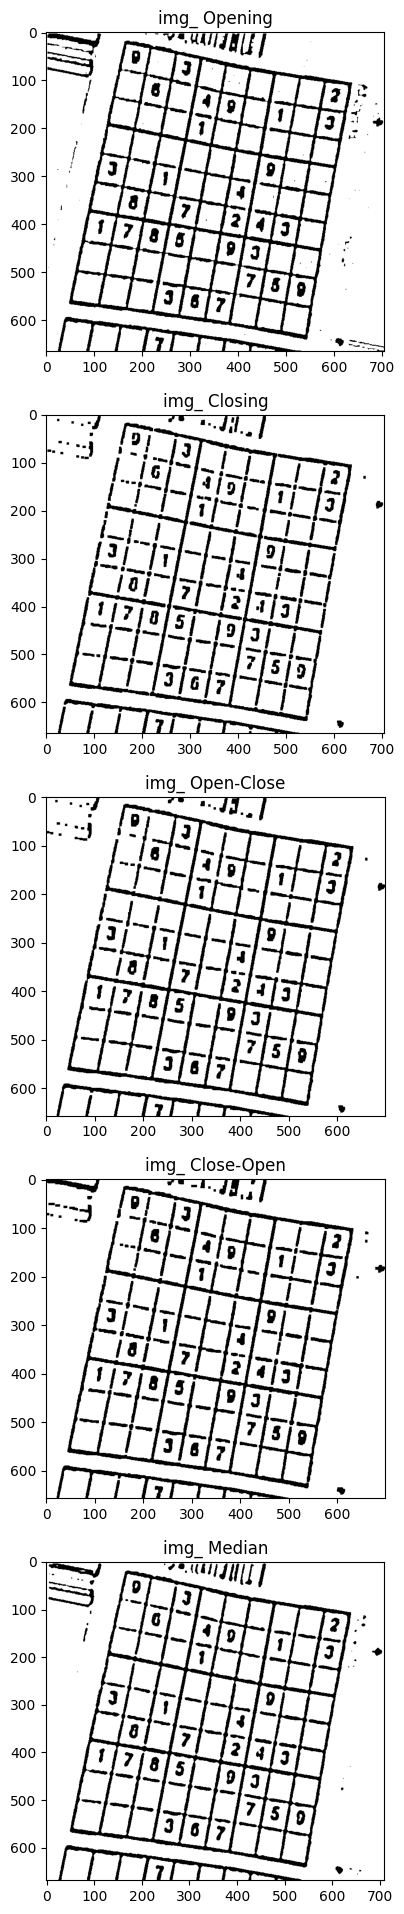

In [167]:
from numpy.lib.stride_tricks import sliding_window_view

def custom_dilate(img, kernel_size):
    v = sliding_window_view(img, (kernel_size, kernel_size))
    v = v.reshape((v.shape[0],v.shape[1],1,kernel_size ** 2))
    v = v.max(axis=-1)
    v = v.reshape((v.shape[0],v.shape[1]))
    return v

def custom_erode(img, kernel_size):
    v = sliding_window_view(img, (kernel_size, kernel_size))
    v = v.reshape((v.shape[0],v.shape[1],1,kernel_size ** 2))
    v = v.min(axis=-1)
    v = v.reshape((v.shape[0],v.shape[1]))
    return v

def opening(img, kernel_size):
    return custom_dilate(custom_erode(img, kernel_size), kernel_size)

def closing(img, kernel_size):
    return custom_erode(custom_dilate(img, kernel_size), kernel_size)

def open_close(img, kernel_size):
    return opening(closing(img, kernel_size), kernel_size)

def close_open(img, kernel_size):
    return closing(opening(img, kernel_size), kernel_size)

def median_filtering(img, kernel_size):
    v = sliding_window_view(img, (kernel_size, kernel_size))
    v = v.reshape((v.shape[0],v.shape[1],1,kernel_size ** 2))
    v = v.mean(axis = -1)
    v = v.reshape((v.shape[0],v.shape[1]))
    _, v_bin = cv2.threshold(v, 127, 255, cv2.THRESH_BINARY)
    return v_bin

img_open = opening(thresh, 5)
img_close = closing(thresh, 5)
img_open_close = open_close(thresh, 5)
img_close_open = close_open(thresh, 5)
img_median = median_filtering(thresh, 5)

f, plot = plt.subplots(5, 1, figsize=(24,24))

plot[0].imshow(img_open, cmap = 'gray')
plot[0].set_title('img_ Opening')
plot[1].imshow(img_close, cmap = 'gray')
plot[1].set_title('img_ Closing')
plot[2].imshow(img_open_close, cmap = 'gray')
plot[2].set_title('img_ Open-Close')
plot[3].imshow(img_close_open, cmap = 'gray')
plot[3].set_title('img_ Close-Open')
plot[4].imshow(img_median, cmap = 'gray')
plot[4].set_title('img_ Median')

A morphological opening filter makes the grid most defined.

In [168]:
img_open = opening(thresh, 5)

In [181]:
# Given binary image of sudoku board, find a mask of the grid
def find_grid(bin):
    H = bin.shape[0]
    W = bin.shape[1]

    entity_map = np.zeros_like(bin, dtype=np.uint32)
    entity_num = 1

    for i in range(H):
        for j in range(W):
            if bin[i,j] != 255 and entity_map[i,j] == 0:
                stack = [(i,j)]
                while stack:
                    x,y = stack.pop()
                    if x >= 0 and x < H:
                        if y >= 0 and y < W:
                            if bin[x,y] != 255 and entity_map[x,y] == 0:
                                entity_map[x,y] = entity_num
                                stack.extend([(x-1,y-1),(x,y-1),(x+1,y-1),
                                              (x-1,y),          (x+1,y),
                                              (x-1,y+1),(x,y+1),(x+1,y+1)])
                entity_num += 1
    
    grid_label = np.argmax(np.bincount(entity_map[entity_map != 0].flatten()))
    grid = np.zeros_like(bin, dtype=np.uint8)
    grid[entity_map == grid_label] = 255

    return grid



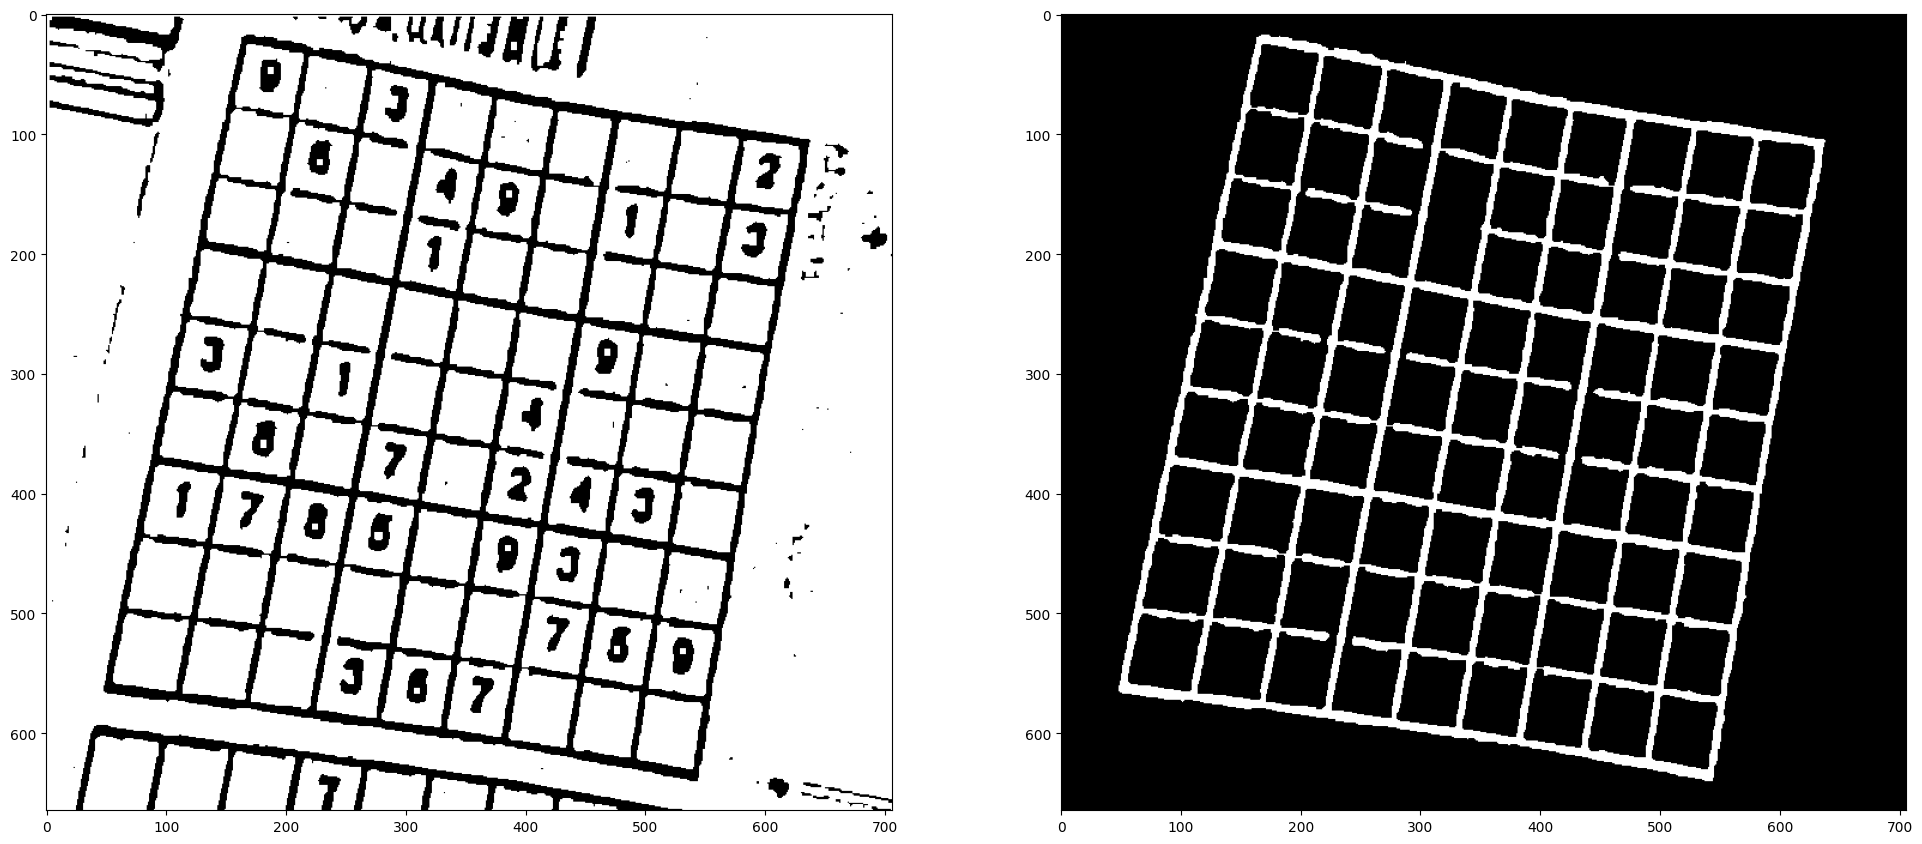

In [183]:
grid_mask = find_grid(img_open)
f, plot = plt.subplots(1, 2, figsize=(24,24))
plot[0].imshow(img_open, cmap = 'gray')
plot[1].imshow(grid_mask, cmap = 'gray')

In [198]:
def find_botL(mask):
    H = mask.shape[0]
    W = mask.shape[1]

    curr_intercept = H-1
    curr_pixel = [H-1, 0]

    while mask[curr_pixel[0], curr_pixel[1]] == 0:
        next_pixel = [curr_pixel[0] + 1, curr_pixel[1] + 1]
        if next_pixel[0] >= H or next_pixel[1] >= W:
            next_pixel = [curr_intercept - 1, 0]
            curr_intercept -= 1
        if next_pixel[0] < 0:
            return (H-1,0)
        curr_pixel = next_pixel
    return curr_pixel

def find_topL(mask):
    H = mask.shape[0]
    W = mask.shape[1]

    curr_intercept = 0
    curr_pixel = [0, 0]

    while mask[curr_pixel[0], curr_pixel[1]] == 0:
        next_pixel = [curr_pixel[0] - 1, curr_pixel[1] + 1]
        if next_pixel[0] < 0 or next_pixel[1] >= W:
            next_pixel = [curr_intercept + 1, 0]
            curr_intercept += 1
        if next_pixel[0] >= H:
            return (0,0)
        curr_pixel = next_pixel
    return curr_pixel

def find_topR(mask):
    H = mask.shape[0]
    W = mask.shape[1]

    curr_intercept = 0
    curr_pixel = [0, W-1]

    while mask[curr_pixel[0], curr_pixel[1]] == 0:
        next_pixel = [curr_pixel[0] - 1, curr_pixel[1] - 1]
        if next_pixel[0] < 0 or next_pixel[1] < 0:
            next_pixel = [curr_intercept + 1, W - 1]
            curr_intercept += 1
        if next_pixel[0] >= H:
            return (0,W-1)
        curr_pixel = next_pixel
    return curr_pixel

def find_botR(mask):
    H = mask.shape[0]
    W = mask.shape[1]

    curr_intercept = H-1
    curr_pixel = [H-1, W-1]

    while mask[curr_pixel[0], curr_pixel[1]] == 0:
        next_pixel = [curr_pixel[0] + 1, curr_pixel[1] - 1]
        if next_pixel[0] >= H or next_pixel[1] < 0:
            next_pixel = [curr_intercept - 1, W - 1]
            curr_intercept -= 1
        if next_pixel[0] < 0:
            return (H-1,W-1)
        curr_pixel = next_pixel
    return curr_pixel

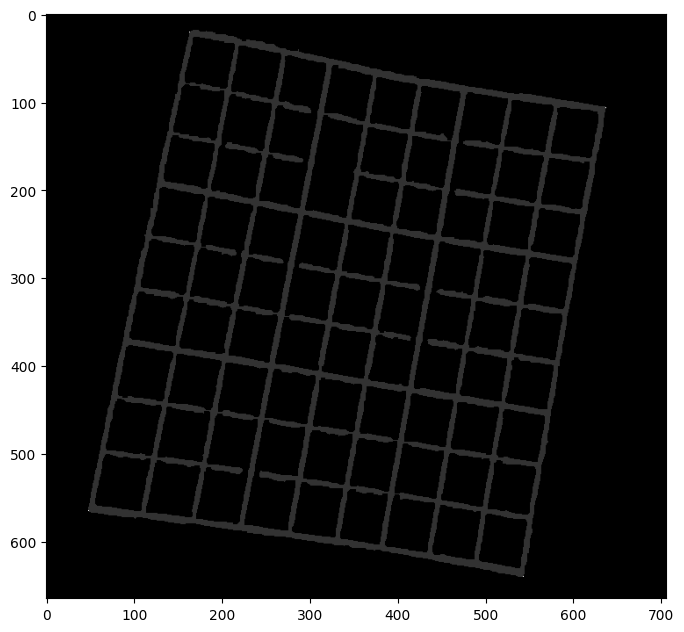

In [202]:
grid_mask = find_grid(img_open)

botL = find_botL(grid_mask)
topL = find_topL(grid_mask)
botR = find_botR(grid_mask)
topR = find_topR(grid_mask)

grid_mask[grid_mask == 255] = 50
grid_mask[botL[0], botL[1]] = 255
grid_mask[topL[0], topL[1]] = 255
grid_mask[botR[0], botR[1]] = 255
grid_mask[topR[0], topR[1]] = 255

f, plot = plt.subplots(1, 1, figsize=(8,8))
plot.imshow(grid_mask, cmap = 'gray')

In [204]:
def get_transform_matrix(input_pts, output_pts):
    matrix = []
    for i in range(4):
        X, Y = input_pts[i]
        x, y = output_pts[i]
        matrix.append([x, y, 1, 0, 0, 0, -1*X*x, -1*X*y])
        matrix.append([0, 0, 0, x, y, 1, -1*Y*x, -1*Y*y])
    
    A = np.matrix(matrix, dtype=np.float32)
    B = np.array(input_pts).reshape(8)
    Lambda = np.linalg.solve(A, B)
    return np.array(Lambda).reshape(8)

def transform(img, matrix):
    height, width = img.shape
    warped_image = np.zeros_like(img)

    for y in range(height):
        for x in range(width):
            src_coords = np.array([x, y, 1], dtype=np.float32)
            dst_coords = np.dot(matrix, src_coords)
            warped_x, warped_y = dst_coords[:2] / dst_coords[2]

            # Check if the new coordinates are within the bounds
            if 0 <= warped_x < width and 0 <= warped_y < height:
                warped_image[int(warped_y), int(warped_x)] = img[y, x]

    return warped_image

In [216]:
H = gray.shape[0]
W = gray.shape[1]

input_pts = [(topL[1], topL[0]),
             (topR[1], topR[0]),
             (botR[1], botR[0]),
             (botL[1], botL[0])]
output_pts = [(0,0), (W, 0), (W, H), (0, H)]

transform_matrix = get_transform_matrix(input_pts, output_pts)
pil_img = Image.fromarray(gray)
pil_img.transform((W, H), Image.PERSPECTIVE, transform_matrix, Image.BICUBIC).show()

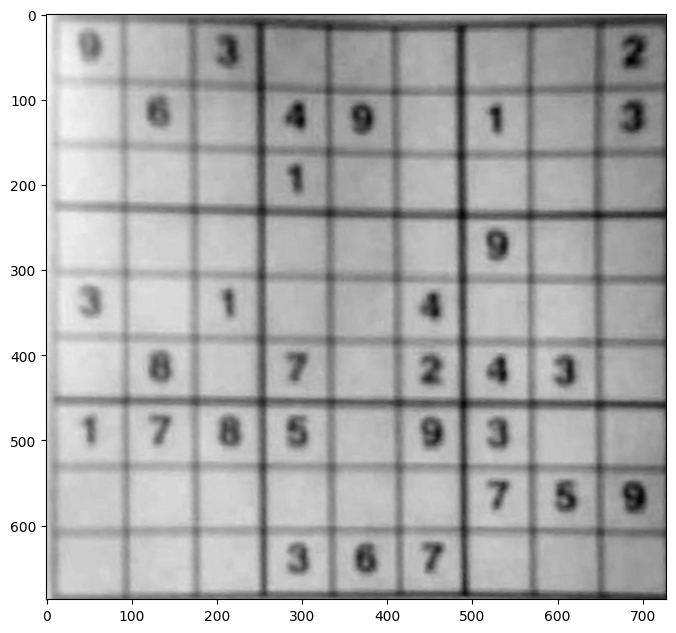

In [226]:
from Sudoku_Board1 import get_board

image = cv2.imread("sudoku_test_1.png")
board = get_board(image)

f, plot = plt.subplots(1, 1, figsize=(8,8))
plot.imshow(board, cmap = 'gray')